In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Cleanup
Let's import the us census tract GIS data and the join it with the demographics data table

In [2]:
tract_shapes = gpd.read_file("detroit/US_tract_2010.shp")
tract_data = pd.read_csv("detroit/nhgis0006_ds181_2010_tract.csv")

tracts_gdf = tract_shapes.merge(tract_data, on="GISJOIN")

In [3]:
#Data is joined now let's filter it down to Wayne county and save to a smaller file
wayne2010 = tracts_gdf.query('STATEA == 26 and COUNTYA == 163')
# If we want to drop empty columns
#wayne2010 = wayne2010.dropna(axis=1, how='all')

wayne2010.to_file("detroit/wayne2010.shp")

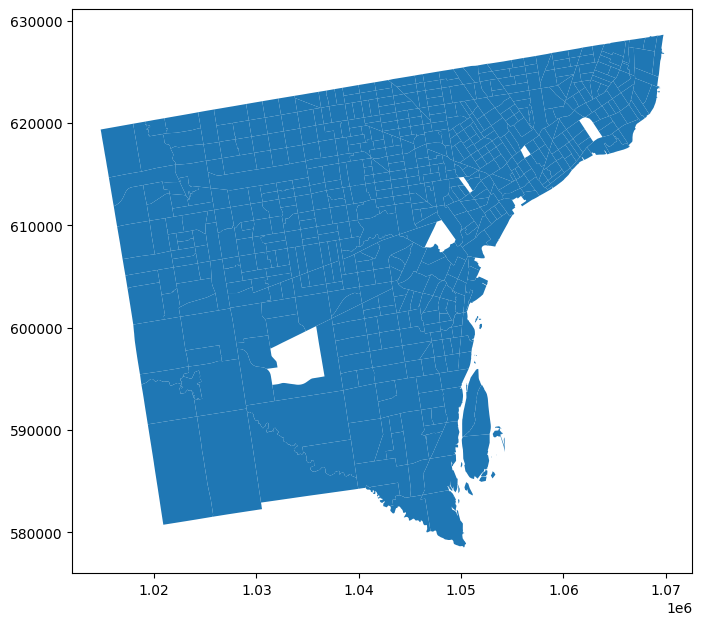

In [4]:
wayne2010 = gpd.read_file("detroit/wayne2010.shp")

#Let's make a plot
wayne2010.plot(figsize=(8, 8));

In [5]:
#how much information does someone's location give you about their race?
def Ent_R_T(df, R_columns, population_column):
    entropy = 0
    totalpop = sum([float(x) for x in df[population_column]])
    R_population_by_tract = {}
    nonR_population_by_tract = {}
    for index, row in df.iterrows():
        R_population_by_tract[row.name] = sum(float(row[c]) for c in R_columns)
        nonR_population_by_tract[row.name] = float(row[population_column]) - R_population_by_tract[row.name]
        if R_population_by_tract[row.name] > 0:
            entropy -= 1/totalpop*R_population_by_tract[row.name]*np.log2(
                    R_population_by_tract[row.name]/float(row[population_column])
        
            )
        if nonR_population_by_tract[row.name] > 0:
            entropy -= 1/totalpop*nonR_population_by_tract[row.name]*np.log2(
                    nonR_population_by_tract[row.name]/float(row[population_column])
                )
    return entropy

In [6]:
#how hard is it to guess someone's race without geographic information?
def Ent_R(df, R_columns, population_column):
    entropy = 0
    totalpop = sum([float(x) for x in df[population_column]])
    R_population = sum(df[c].sum() for c in R_columns)
    nonR_population = totalpop - R_population
    entropy -= 1/totalpop*R_population*np.log2(
            R_population/totalpop
    )
    entropy -= 1/totalpop*nonR_population*np.log2(
            nonR_population/totalpop
    )
    return entropy

### And now we compute entropy segregation scores

In [7]:
#we'll do Hispanic 2010 as an example, so we need all the Hispanic columns
#which columns you need changes by census cycle so be careful!
race_columns = [
    'LHMAAD001',
]
census_cycle_data = wayne2010 
EntRT = Ent_R_T(census_cycle_data, race_columns, "LHM001")
EntR = Ent_R(census_cycle_data, race_columns, "LHM001")
print("Ent(R|T): {:0.3f}".format(EntRT))
print("Ent(R): {:0.3f}".format(EntR))
print("Seg(R,T) = Ent(R|T)/Ent(R) = {:0.3f}".format(EntRT/EntR))

Ent(R|T): 0.372
Ent(R): 0.977
Seg(R,T) = Ent(R|T)/Ent(R) = 0.380


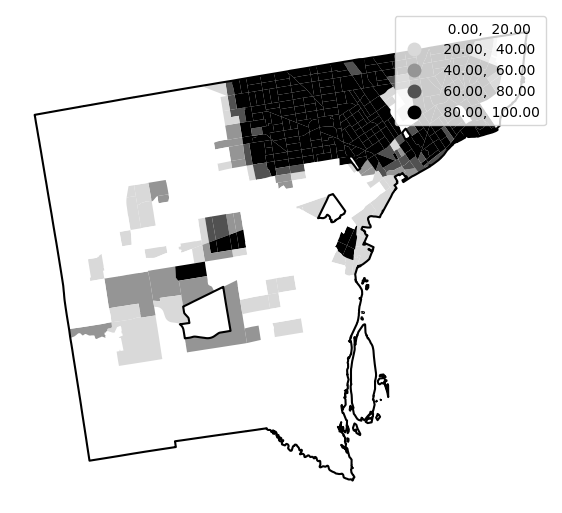

In [8]:
"""
       LHM001: Total population
    LHMAAA001: White alone
    LHMAAC001: Black or African American alone
    LHMAAD001: Black or African American alone or in combination with one or more other races
    LHMAAE001: American Indian and Alaska Native alone
    LHMAEQ001: Asian alone
    LHMAGN001: Native Hawaiian and Other Pacific Islander alone
    LHMAIH001: Some Other Race alone or in combination with one or more other races
"""
race_columns = [
    'LHMAAD001'
]

# we can also look at choropleths for this race and census cycle
fig, ax = plt.subplots(figsize=(7,7))
wayne2010.plot(
    column=100*wayne2010[race_columns].sum(axis=1).divide(wayne2010["LHM001"]),
    cmap="Greys",
    legend=True,
    scheme='user_defined',
    classification_kwds={'bins':[20, 40, 60, 80, 100]},
    ax=ax
)
wayne2010['dummy'] = 1
citytracts = wayne2010.dissolve(by='dummy')
citytracts.boundary.plot(
    ax=ax,
    edgecolor='black'
)
plt.axis('off')
plt.show()